# Classroom 4 - Basic machine learning with ```Pytorch```

The first thing we need to do for this workshops is install both ```pytorch``` and ```scikit-learn```, along with some other packages we need for this week. You may have already installed some of this for previous classes (if so, some of this will be skipped).

```
pip install --upgrade pip
pip install torch scikit-learn matplotlib sympy datasets
```

__Load packages__

In [1]:
# for data structures and efficient calculations
import torch
import numpy as np

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# matplotlib
import matplotlib.pyplot as plt

# library for symbolic computations (we use it to plot functions)
import sympy

# huggingface datasets
from datasets import load_dataset

__Creating a tensor__

A tensor is a data structure very similar to numpy arrays.  
Just like numpy arrays, they can store scalars (0D tensors), vectors (1D tensors), matrices (2D tensors) and more (many-D tensors). 

Different from numpy arrays, tensors have handy characteristics that make it possible to easily compute and store gradients, which is useful for machine learning optimization. This is the data structure that PyTorch uses to fit models.

In [2]:
x_tensor = torch.tensor([[1., -1.], 
                         [1., -1.]])

type(x_tensor)

torch.Tensor

In [3]:
x_tensor

tensor([[ 1., -1.],
        [ 1., -1.]])

There are different ways to create tensors (from scratch, or by "tensorifying" other data structures, such as arrays).  
Take a look at the documentation for more details: https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html

__Tensor to numpy array__

Tensors can easily be transformed into numpy arrays (e.g., once you're done with training a neural network), which may be easier to use with tools from scientific computing libraries such as scikit-learn or scipy.

In [4]:
# tensor to numpy
x_array = x_tensor.numpy()
type(x_array)

numpy.ndarray

__And back again__

In [5]:
# numpy to tensor
x_tensor2 =torch.tensor(x_array)
type(x_tensor2)

torch.Tensor

In [6]:
# check for identity
x_tensor2 == x_tensor

tensor([[True, True],
        [True, True]])

As you can see, the data has not been changed by these transformation: all that has changed is the data structure that the data is stored in.

## Stochastic gradient descent

Remember when we talked about how to train a neural network in lecture?  
We need to pass the activations through our neural network, and at the end measure its success using a loss function.  
Then we will optimize the neural network, which means adjusting its weights and biases to get a better result, using stochastic gradient descent;

The goal is to find the value of the parameters (our `x`) which corresponds to the lowest possible value of the loss function (our `y`).  
This can be done through a process called gradient descent, which involves:
1. starting from a random initial value for x 
2. computing the derivative of the function (`d_x`) for that value
3. computing a new value of x, with this formula: ```x_new = x_old - learning_rate * d_x```
4. continuing, until we find an x which yields very low values of y.

Let's try this out for a function (could be almost any function really, but for this one we know the global minimum).

Our function will be: `y = x**2`.  
Let's see how our function looks:

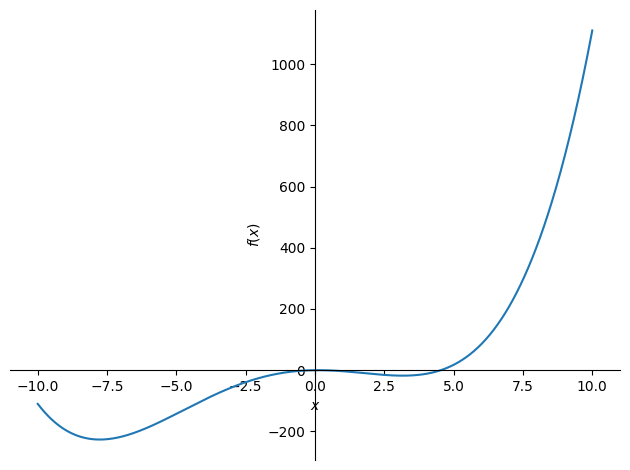

In [42]:
x = sympy.symbols('x')
sympy.plot(0.6*x**3-5*x**2+x+0.1*x**4)

Let's begin by creating an initial value for ```x``` and defining the function ```y```.  
The goal is to find the _minimum_ value of y, i.e. in this case the turning point of the function.

In [59]:
x = torch.tensor([3.], 
                 requires_grad=True)

In [60]:
y = 0.6*x**3-5*x**2+x+0.1*x**4
y

tensor([-17.7000], grad_fn=<AddBackward0>)

The output of this is the value of our function for `x=3`. To find lower values of y, let's perform gradient descent.  
In PyTorch, we can do so using optimizers (https://pytorch.org/docs/stable/optim.html), which implement multiple optimization algorithms including stochastic gradient descent (`SGD`).

__Create SGD optimizer__

In doing so, we also set a learning rate, which is one of the parameters for the optimizer.

In [45]:
optimizer = torch.optim.SGD([x],     # starting value
                            lr=0.00001) # learning rate


__Calculate the gradient__

Let's compute the derivative of our function `y = f(x)` for our current value of `x`.

We do so by running a _backwards pass_ which computes the derivative of the function `y` for a given value `x`.

In [46]:
y.backward()

In [58]:
print(x.grad) # examine the resulting gradient

None


__Make a step in the right direction__

Using information on the gradient, the optimizer will update the value of `x` based on the update equation (`x_new = x_old - learning_rate * d_new`).
Let's first manually check what the new value of x should be.

In [48]:
x - 0.00001 * x.grad

tensor([3.0000], grad_fn=<SubBackward0>)

Now let's do this with the optimizer, which is how you would normally do that when training a network.

In [49]:
# step in the direction to minimize y
optimizer.step()

In [50]:
# set the gradient to zero. (This is a bit weird but required)
optimizer.zero_grad()

In [51]:
x

tensor([3.0000], requires_grad=True)

The optimizer has computed the new value of x. Let's check that this corresponds to a better value of `y`, compared to the previous `x`.

In [33]:
x**2

tensor([2.2034e-16], grad_fn=<PowBackward0>)

It does, this is working as desired... but can we do better?

__Run this for 1000 steps__

We can of course do better than this (we know that the minimum for y is around zero), so let's see what happens if we run these updates 1000 times.

In [52]:
values = [] # here we store the values of y as we compute them

for i in range(1000):
    #print(x)

    # forward pass / or just calculate the outcome
    y = 0.6*x**3-5*x**2+x+0.1*x**4
    values.append(y.detach().numpy()) # detach removes gradient information and allows us to transform tensors into arrays
 
    # backward pass on the thing we want to minimize
    y.backward()

    # take a step in the "minimize direction"
    optimizer.step()

    # zero the gradient
    optimizer.zero_grad()


In [53]:
x

tensor([3.0189], requires_grad=True)

We have converged to the value of `x` which yields the minimum `y`. Now let's visualize the history of this process, seeing how the value of `y` changed at each step.

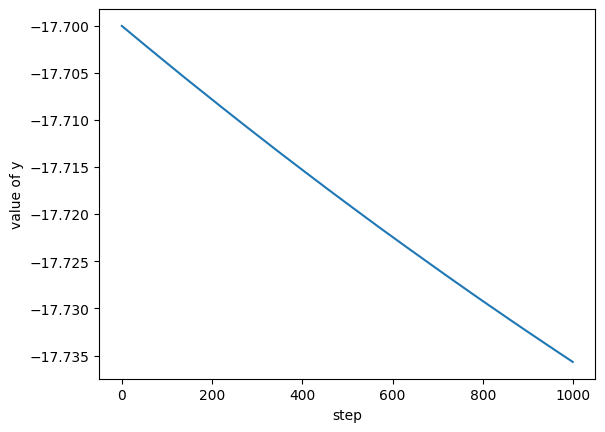

In [57]:
plt.plot(range(1000), values)
plt.xlabel('step')
plt.ylabel('value of y')
plt.show()

The process we have performed here is analogous to what you do when training any neural network using stochastic gradient descent, or similar optimization algorithms. In that case, the function you will be working with will be the **loss function** for your network (e.g., `cross-entropy loss`), rather than our polynomial function. 
The curve we have just plotted here will describe changes in your loss as a function of training. If training is going well, you will have a fairly smoothly descending curve. If the curve is much bumpier or not monotonically descending, it may be a symptom of your training process not being optimal (e.g., the learning rate not being good, or the loss function being ill-defined).

### Bonus task
- Try and define some functions of your own and see if you can find the minimum. (There are tools online where you can check what the actual minimum is, to see if the algorithm gets it right!)
- What happens if you change the learning rate? Try set it to unrealistically high or low values.

## Building a Neural Logistic Regression Classifier

So far we haven't actually looked at any text data, and we have looked at a toy example of optimization. Time to move on to a real example. 

In class 3, we looked at an example of text classification using term-document matrices to classify the sentiment of some sentences. In that case, we used the `scikit-learn` implementation of logistic regression. 

Here, we will solve the same problem using a neural network classifier. The advantage of this approach, is that we could in theory add a number of intermediate layers to improve the performance of our models (minding that overly complex networks may also *hinder* performance by overfitting).

First, let's load the data. 
Pick any of the datasets from last weeks, or your own.

In [22]:
# sentiment dataset from last class
dataset = load_dataset("stanfordnlp/imdb")

# toxicity dataset from last class (huge)
# dataset = load_dataset("FredZhang7/toxi-text-3M")

# extra sentiment dataset
# dataset = load_dataset("glue", "sst2")

# select the train split
data = dataset["train"]
X = data["text"]
y = data["label"]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

__Creating train/test splits__

A common practice when building ML/DL models is to use explicitly defined subsets of data for different tasks - [training vs testing](https://upload.wikimedia.org/wikipedia/commons/b/bb/ML_dataset_training_validation_test_sets.png), for example. 

Although the example datasets already come in train-test splits, it is useful to know how to do it on your own.  
```scikit-learn``` has a simple tool for this.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], 
                                                    data["label"], 
                                                    test_size=0.2, 
                                                    random_state=42)

__Creating a document vectorizer__

Similar to what we did in the previous class, we now transform our sentences into a matrix which has documents as rows, and words as columns, and whose values are normalized frequency counts.  
We do it using `TfidfVectorizer` from `sklearn` (or `CountVectorizer`). Do you remember what the difference was?

__Initialize vectorizer__

In [62]:
vectorizer = TfidfVectorizer()

__Fit to the training data__

In [63]:
# vectorized training data
X_train_vect = vectorizer.fit_transform(X_train)

# vectorized test data
X_test_vect = vectorizer.transform(X_test)

__Convert to tensors__

In [64]:
# vectorized training data
X_train_vect = torch.tensor(X_train_vect.toarray(), dtype=torch.float)

# vectorized test data
X_test_vect = torch.tensor(X_test_vect.toarray(), dtype=torch.float)

__Convert labels__ to tensors

In [65]:
# training labels
y_train = torch.tensor(list(y_train), dtype=torch.float)
# test labels
y_test = torch.tensor(list(y_test), dtype=torch.float)

In [66]:
# reshaping
y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

#### Specifying model, loss, and optimizer
Ok, so, now we have inputs and labels for our model. What we need to do is specify three things:
- __our model__: we want to specify the architecture of our model;
- __our loss function__: we want to specify what function we are using to optimize model weights to producing the best possible predictions. Since this is a binary classification task, we will use the cross-entropy function we have discussed in class;
- __our optimizer__: the process by which we optimize weights. We will use Stochastic Gradient Descent.

__Initialization parameters for Logistic Regression__

To define the architecture, we need to know how many inputs we have, i.e., the dimensionality of our vectors. We also need to know what the dimensionality of the output is.

In [67]:
n_samples, n_features = X_train_vect.shape
input_size = n_features 
output_size = 1

__1. Creating the model__

Computing the output with a simple logistic regression model implies two things. First, we multiply each of our inputs by the corresponding weights, sum them, and add the bias. This is what a __linear__ (or __fully connected__) layer in a neural network architecture can do for us. Second, we apply a sigmoid transformation to the output.

Let's start by implementing this simple model as a neural network. All we need is a `Linear` layer which takes a number of inputs corresponding to the number of dimensions of our document vectors, and outputs a single value.

In [85]:
# create a weight and biases (betas and intercept) initialized 'randomly'
model = torch.nn.Linear(input_size, output_size)
learning_rate = 0.001 # feel free to change this

This comes with randomly initialized weights and biases for the linear layer. 

In [69]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0020,  0.0002, -0.0009,  ..., -0.0023,  0.0025,  0.0036]],
       requires_grad=True), Parameter containing:
tensor([0.0009], requires_grad=True)]


__2-3. Defining the loss and the optimizer__

In the first part of our notebook, we manually specified the function we were trying to minimize. For common loss functions, PyTorch comes with predefined classes. Our cross-entropy loss is for example implemented in this `BCELoss` class. You can explore other losses here: https://pytorch.org/docs/stable/nn.html.

As to the optimizer, we use again the Stochastic Gradient Descent optimizer.

In [86]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), # parameters to optimize
                            lr=learning_rate,    # the speed in which we optimize them  / how fast the model learns (think step size) 
                            ) 
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = learning_rate)

__Run the model for 100 epochs__
Ok! Now we have some data, a model, a loss function, and a way to update the model to try minimize the loss function. Let's run 100 passes of gradient descent (on the full dataset, not on batches for now) and see where we get.

In [87]:
epochs = 100
sigmoid = torch.nn.Sigmoid() # somet pytorch util to calculate the sigmoid function

for epoch in range(epochs):
    y_predicted = sigmoid(model(X_train_vect))

    # calucate loss
    loss = criterion(y_predicted, y_train)
    
    # Backward pass / gradient and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

epoch: 10, loss = 0.6836
epoch: 20, loss = 0.6733
epoch: 30, loss = 0.6632
epoch: 40, loss = 0.6533
epoch: 50, loss = 0.6436
epoch: 60, loss = 0.6342
epoch: 70, loss = 0.6250
epoch: 80, loss = 0.6160
epoch: 90, loss = 0.6073
epoch: 100, loss = 0.5988


__Check performance against test data__

We use some utils from scikit-learn to do so.

In [88]:
# these are the predictions of the model for the test set
predicted = sigmoid(model(X_test_vect)).detach().numpy()

In [89]:
accuracy_score(y_test, predicted>0.5) 
#accuracy with SGD 0.608 lr = 0.01
#accuracy with AdamW 0.0.8676 lr = 0.01
#accuracy with AdamW 0.8332 lr =0.001

0.8332

In [90]:
print(classification_report(y_test, 
                            np.where(predicted > 0.5, 1, 0),
                            target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83      2515
    Positive       0.83      0.84      0.83      2485

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



__Bonus task__:

Our accuracy is better than chance, but not great. It may be due to many different reasons, such as our learning rate not being great. What happens if you change the learning rate? What happens if you use a different optimizer? Try uncomment the `Adam` optimizer defined in the optimizer cell.

### Deep(er) networks
So far we have worked with a very simple model. But as we have seen in class, you can create arbitrarily complex models. Let's do that using PyTorch. We can use PyTorch Module class, which allows us to build arbitrarily complex models.

In [91]:
class Model(torch.nn.Module):
    def __init__(self, n_input_features=10):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_input_features, 30)
        self.linear2 = torch.nn.Linear(30, 30)
        self.linear3 = torch.nn.Linear(30, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred

In [96]:
# initialize model, loss, and optimizer
model = Model(n_input_features=n_features)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [93]:
print(model) # this is how our model looks like -- with some sigmoid activations in between.

Model(
  (linear1): Linear(in_features=68268, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=1, bias=True)
)


Now let's train the model like we did before.

In [97]:
epochs = 40
loss_history = [] # here we will store the value of the loss at each epoch

for epoch in range(epochs):
    
    y_predicted = model(X_train_vect)
    loss = criterion(y_predicted, y_train)
    loss_history.append(loss)
    
    # Backward pass / gradient and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

epoch: 10, loss = 0.6759
epoch: 20, loss = 0.5467


KeyboardInterrupt: 

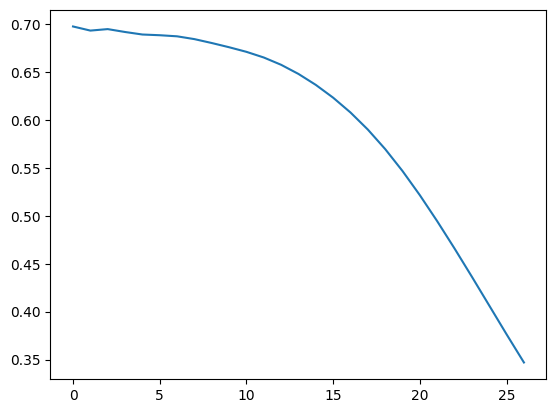

In [98]:
loss_H = [val.item() for val in loss_history]
fig, ax = plt.subplots()
ax.plot(loss_H)

In [99]:
predicted = sigmoid(model(X_test_vect)).detach().numpy()

In [100]:
print(classification_report(y_test, 
                            np.where(predicted > 0.5, 1, 0),
                            target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2515
    Positive       0.50      1.00      0.66      2485

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.33      5000
weighted avg       0.25      0.50      0.33      5000



/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


__Task__
- What happens to performance by training a more complex model? 
- How does perfomance change as the complexity of the model increases (e.g., if you add more layers, or use wider hidden layers)?
- Do training and test performance change differently, as model complexity increases?

__Bonus task__ [advanced]: 

Note that we have implemented classifiers using counts as inputs, but we could be doing the same thing using the average of Word2Vec vectors for all words in each target sentence. If you run out of things to do and your are very proficient in Python, you can try implement this approach!